In [2]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import ydata_profiling
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [14]:
num_layer = 5
dataset_dir = 'Dataset/ModelNet40-path'
base_path = Path('Dataset')

In [19]:
# we only use files that are existed
metadata = pd.read_csv(base_path/'metadata_modelnet40.csv')

dataset_dir = base_path/'ModelNet40-path'
all_files = [f[len(str(dataset_dir))+1:].replace('\\', '/')
            for f in glob.glob(f'{dataset_dir}/*/*/*')]
metadata.object_path = metadata.object_path.\
                        str.replace('.off', '.path', regex=True)
metadata = metadata.query('`object_path` in @all_files')
metadata

,object_id,class,split,object_path
0,airplane_0627,airplane,test,airplane/test/airplane_0627.path
1,airplane_0628,airplane,test,airplane/test/airplane_0628.path
2,airplane_0629,airplane,test,airplane/test/airplane_0629.path
3,airplane_0630,airplane,test,airplane/test/airplane_0630.path
4,airplane_0631,airplane,test,airplane/test/airplane_0631.path
...,...,...,...,...
12306,xbox_0099,xbox,train,xbox/train/xbox_0099.path
12307,xbox_0100,xbox,train,xbox/train/xbox_0100.path
12308,xbox_0101,xbox,train,xbox/train/xbox_0101.path
12309,xbox_0102,xbox,train,xbox/train/xbox_0102.path


In [22]:
train_metadata = metadata.query('split == "train"')
test_metadata = metadata.query('split == "test"')
train_paths = [dataset_dir/fp for fp in train_metadata.object_path]
train_labels = train_metadata['class']
test_paths = [dataset_dir/fp for fp in test_metadata.object_path]
test_labels = test_metadata['class']
num_labels = len(set(train_labels))
num_labels

29

In [23]:
def load_path(file_path):
    path_graph = open(file_path, 'r').read().split('\n')[1:]
    num_vert, num_edge = [int(i) for i in path_graph[0].split()]
    verts = [[float(v_s) for v_s in v_str.split()] for v_str in path_graph[1:num_vert+1]]
    edges = [[int(e_s) for e_s in e_str.split()] for e_str in path_graph[num_vert+1:]][:-1]
    verts = np.array(verts)
    return verts, edges
  
file_path = metadata.object_path[0].replace('.off', '.path')
verts, edges = load_path(dataset_dir/file_path)

100%|██████████| 700/700 [00:00<00:00, 1029.63it/s]


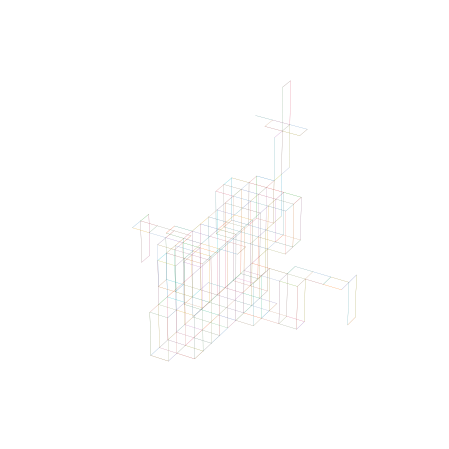

In [24]:
def visualize(verts, edges):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    for edge in tqdm(edges):
        ax.plot(
            [verts[edge[0], 0], verts[edge[1], 0]],
            [verts[edge[0], 1], verts[edge[1], 1]],
            [verts[edge[0], 2], verts[edge[1], 2]],
            linewidth=0.1,
        )
    ax.axis('off')
    plt.show()

visualize(verts, edges)

In [30]:
def get_bitmap(verts, axis, precision=7):
    verts_ = (np.round(verts*2**precision)).astype('int')
    bitmap = np.zeros((2**precision,2**precision))
    for i,j in verts_[:,axis]:
        bitmap[i,j] += 1
    return bitmap / np.max(bitmap)

def get_bitmaps(verts, edges):
    bm1 = get_bitmap(verts, [0,1]).tolist()
    bm2 = get_bitmap(verts, [1,2]).tolist()
    bm3 = get_bitmap(verts, [2,0]).tolist()
    return [bm1, bm2, bm3]

# bitmap_0 = get_bitmap(verts, [0,1])
# bitmap_1 = get_bitmap(verts, [1,2])
# bitmap_2 = get_bitmap(verts, [2,0])
bitmaps = get_bitmaps(verts, edges)

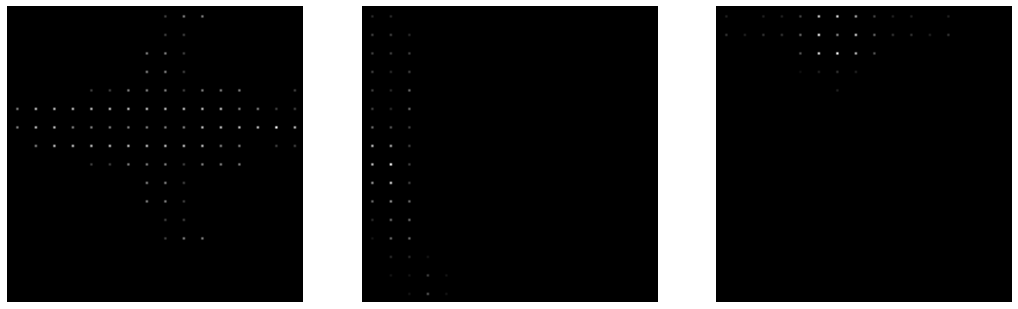

In [31]:
def visualize_bitmap(ax, bitmap):
    ax.imshow(bitmap, cmap='gray')
    ax.axis('off')

fig, ax = plt.subplots(1,3, figsize=(18,6))
visualize_bitmap(ax[0], bitmaps[0])
visualize_bitmap(ax[1], bitmaps[1])
visualize_bitmap(ax[2], bitmaps[2])
plt.show()

In [32]:
# convert data to bitmaps
train_data = [get_bitmaps(*load_path(fp)) for fp in tqdm(train_paths)]
test_data = [get_bitmaps(*load_path(fp)) for fp in tqdm(test_paths)]

100%|██████████| 1530/1530 [00:14<00:00, 105.65it/s]


In [ ]:
# save all data
os.makedirs('saved_data', exist_ok=True)
with open('saved_data/test_dataset.pkl', 'wb') as f:
   pickle.dump((test_data, test_labels.tolist()), f)
with open('saved_data/train_dataset.pkl', 'wb') as f:
   pickle.dump((train_data, train_labels.tolist()), f)